In [43]:
# MCMC evaluation of E2 effective charge distributions
# Fox 2022
#
# more general version of the MCMC scripts with version numbers
# can set which variables to model in argument


import numpy as np
import os, sys
from glob import glob
from tqdm import tqdm
from time import time
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
import pandas as pd
import pickle as pkl
import emcee
from multiprocessing import Pool
from scipy.optimize import minimize, minimize_scalar

    
def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

def Bweisskopf(l,A):
    # Weisskopf (single-particle) estimate in e^2 fm^2l
    return (1/(4*np.pi)) * (3/(3+l))**2 * (1.2*A**(1/3))**(2*l)

# define prior parameter values
e_p_brown, e_n_brown = 1.36, 0.45
mu_blomqvist, beta_blomqvist = 0.9, 0.7 

prior_params = [e_p_brown,e_n_brown,mu_blomqvist,beta_blomqvist]

def Bth_model_Wu(parameters,Mth_p_vec,Mth_n_vec,A_vec):
    e_p, e_n, mu, beta = parameters
    b_sqr_vec = mu*A_vec**(1/3) + beta
    Bth_vec = b_sqr_vec**2 * ( e_p * np.array(Mth_p_vec) + e_n * np.array(Mth_n_vec))**2
    single_particle_estimates = Bweisskopf(2,A_vec)
    return Bth_vec / single_particle_estimates

print('Loading data...')
fn_data_for_model = 'e2_data_for_model_050222.pkl'
with open(fn_data_for_model,'rb') as fh:
    [nuc_dict_list, Mth_p_usdb_list,Mth_n_usdb_list,Mth_p_vec_list,Mth_n_vec_list,title_string_list, Bexp_e2fm4_list, Bexp_unc_e2fm4_list, Bexp_Wu_list, Bexp_unc_Wu_list] = pkl.load(fh)

Loading data...


In [44]:
# nuc_dict_list

In [45]:
# relative_err_threshold = 1.0
relative_err_threshold = None

In [46]:
# need to grab first element of each df row
Bexp_Wu_list = [x.iloc[0] for x in Bexp_Wu_list]
Bexp_unc_Wu_list = [x.iloc[0] for x in Bexp_unc_Wu_list]
A_vec = np.array([nuc_dict['A'] for nuc_dict in nuc_dict_list])
Bexp_Wu_vec = np.array(Bexp_Wu_list)
Bexp_unc_Wu_vec = np.array(Bexp_unc_Wu_list)
Mth_p_usdb_vec = np.array(Mth_p_usdb_list)
Mth_n_usdb_vec = np.array(Mth_n_usdb_list)
Mth_p_array = np.array(Mth_p_vec_list)
Mth_n_array = np.array(Mth_n_vec_list)
n_transitions, n_samples = Mth_p_array.shape

# drop transitions with large relative error
if relative_err_threshold is not None:
    Bth_usdb_prior = Bth_model_Wu(prior_params, Mth_p_usdb_vec, Mth_n_usdb_vec,A_vec)
    Berr_rel = (Bexp_Wu_vec - Bth_usdb_prior)/Bexp_Wu_vec
    mask = np.abs(Berr_rel) < relative_err_threshold

    A_vec = A_vec[mask]
    Bexp_Wu_vec = Bexp_Wu_vec[mask]
    Bexp_unc_Wu_vec = Bexp_unc_Wu_vec[mask]
    Mth_p_usdb_vec = Mth_p_usdb_vec[mask]
    Mth_n_usdb_vec = Mth_n_usdb_vec[mask]
    Mth_p_array = Mth_p_array[mask]
    Mth_n_array = Mth_n_array[mask]
    n_transitions, n_samples = Mth_p_array.shape

def chi_squared(parameters,sigmaB_apriori):
    sqr_errors = (Bexp_Wu_vec - Bth_model_Wu(parameters,Mth_p_usdb_vec,Mth_n_usdb_vec,A_vec))**2
    B_unc_sqr_vec = np.array( [(sigmaB_apriori**2 + sigmaB**2) for sigmaB in Bexp_unc_Wu_vec])
    R_sqr =  sqr_errors / B_unc_sqr_vec
    return  np.sum(R_sqr)

def objective(sigmaB_apriori):
    X2 = chi_squared(prior_params,sigmaB_apriori)
    dof = n_transitions - 66
    return (X2/dof - 1)**2

In [47]:
print('Finding a priori B-value uncertainty...')
opt_result = minimize_scalar(objective)
sigmaB_apriori = opt_result.x
print(f'A priori B(E2) uncertainty = {sigmaB_apriori}')
sigma_B_sqr_vec = [(sigmaB_apriori**2 + sigmaB**2) for sigmaB in Bexp_unc_Wu_vec]

B_unc_sqr_vec = np.array( [sigmaB_apriori**2 + sigmaB**2 for sigmaB in Bexp_unc_Wu_vec] )
mu_std = 1
beta_std = 1
ep_bounds = (1.,2.)
en_bounds = (0.,1.)

def ep_log_prior(ep):
    if ep>ep_bounds[0] and ep<ep_bounds[1]:
        return 0.
    else:
        return -np.infty
    
def en_log_prior(en):
    if en>en_bounds[0] and en<en_bounds[1]:
        return 0.
    else:
        return -np.infty
    
def normal_pdf(x,m,s):
    norm = (s * np.sqrt(2*np.pi))**-1
    return norm * np.exp( - 0.5 * ((x-m)/s)**2)

def log_normal_pdf(x,m,s):
    norm = (s * np.sqrt(2*np.pi))**-1
    return np.log(norm) - 0.5 * ((x-m)/s)**2

def mu_log_prior(mu):
    return log_normal_pdf(mu,mu_blomqvist,mu_std)
    
def beta_log_prior(beta):
    return log_normal_pdf(beta,beta_blomqvist,beta_std)

Finding a priori B-value uncertainty...
A priori B(E2) uncertainty = 5.399283009004633


In [48]:
# variables = 'eff_charges'
variables = 'osc_length_params'

In [49]:
Bexp_tiled = np.tile(Bexp_Wu_vec.reshape(n_transitions,1),n_samples)
B_unc_sqr_tiled = np.tile(B_unc_sqr_vec.reshape(n_transitions,1),n_samples)
single_particle_estimates = Bweisskopf(2,A_vec)
spe_tiled = np.tile(single_particle_estimates.reshape(n_transitions,1),n_samples)

if variables == 'eff_charges':
    def log_prior(theta):
        return ep_log_prior(theta[0]) + en_log_prior(theta[1])
        
    # redefine likelihood to be faster
    b4_vec = (mu_blomqvist*A_vec**(1/3) + beta_blomqvist)**2
    b4_tiled = np.tile(b4_vec.reshape(n_transitions,1),n_samples)
    def log_posterior(theta):
        # sum over data, average over samples
        sqr_error_tiled = ( Bexp_tiled - (b4_tiled/spe_tiled)*(theta[0]*Mth_p_array + theta[1]*Mth_n_array)**2 )**2
        log_likelihood =  - 0.5 * np.sum(sqr_error_tiled / B_unc_sqr_tiled) / n_samples
        return log_prior(theta) + log_likelihood
    
    def starting_point():
        ep = np.random.rand() + 1
        en = np.random.rand()
        return [ep,en]
    
elif variables == 'osc_length_params':
    def log_prior(theta):
        return mu_log_prior(theta[0]) + beta_log_prior(theta[1])
    
    Bth_array = (e_p_brown*Mth_p_array + e_n_brown*Mth_n_array)**2
    
    def log_posterior(theta):
        # sum over data, average over samples
        b4_vec = (theta[0]*A_vec**(1/3) + theta[1])**2
        b4_tiled = np.tile(b4_vec.reshape(n_transitions,1),n_samples)
        sqr_error_tiled = ( Bexp_tiled - (b4_tiled/spe_tiled)*Bth_array )**2
        log_likelihood =  - 0.5 * np.sum(sqr_error_tiled / B_unc_sqr_tiled) / n_samples
        return log_prior(theta) + log_likelihood
    
    def starting_point():
        [mu,beta] = [-1.,-1.]
        while mu<0. and beta<0.:
            mu = mu_std*np.random.normal() + mu_blomqvist
            beta = beta_std*np.random.normal() + beta_blomqvist
        return [mu,beta]

In [50]:
def objective(theta):
    return -log_posterior(theta)

# opt = minimize(objective,x0=[1.5,0.5])
opt = minimize(objective,x0=[0.9,0.7])
opt

      fun: 44.96387477256713
 hess_inv: array([[ 0.08175888, -0.2367663 ],
       [-0.2367663 ,  0.69260715]])
      jac: array([-4.76837158e-07, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([0.70002452, 1.3330998 ])

In [51]:
n_transitions

153

In [52]:
n_walkers = 16
n_steps = 1000
n_params = 2
use_pool = True

q0 = [starting_point() for _ in range(n_walkers)]

print('Beginning MCMC...')
print(f'N walkers: {n_walkers}')
print(f'N steps: {n_steps}')


with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
    start = time()
    sampler.run_mcmc(q0, n_steps, progress=True,);
    end = time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))


Beginning MCMC...
N walkers: 16
N steps: 1000


100%|██████████| 1000/1000 [02:01<00:00,  8.24it/s]


Multiprocessing took 121.4 seconds


In [53]:
def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

def make_hist(data,title_string,label):
    y = data.flatten()
    n_bins = 40
    plt.figure(figsize=(10,7))
    plt.hist(y,bins=n_bins,density=True)
    y_mean = np.mean(y)
    y_std = np.std(y)
    plt.title(f"{title_string}\n{y_mean:5.3} +/- {y_std:5.3}")
    plt.xlabel(label)
    plt.ylabel('Density (no units)')
    plt.xticks(rotation=45)
    plt.show()

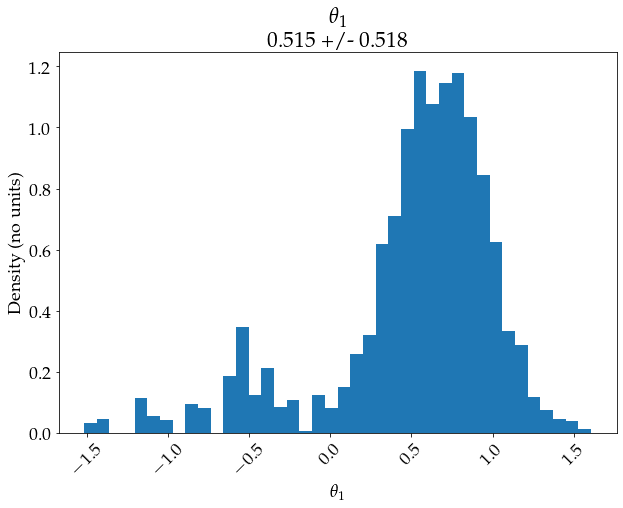

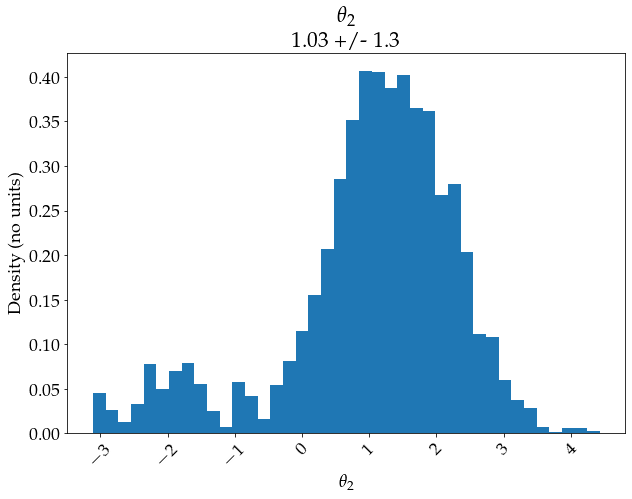

In [54]:
chain = sampler.chain
warmup = 400
theta_1_trace = chain[:,warmup:,0].flatten()
theta_2_trace = chain[:,warmup:,1].flatten()
make_hist(theta_1_trace,r'$\theta_1$',r'$\theta_1$')
make_hist(theta_2_trace,r'$\theta_2$',r'$\theta_2$')